Copyright (c) 2020 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Demo of AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to ues FLAML library.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the [notebook] option:
```bash
pip install flaml[notebook]
```

## 2. Real Data Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id = 1169, data_dir = './')

load dataset from ./openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', # primary metrics can be chosen from: ['accuracy','roc_auc','f1','log_loss','mae','mse','r2']
    "estimator_list": ['lgbm', 'rf', 'xgboost'], # list of ML learners
    "task": 'classification', # task type    
    "sample": False, # whether to subsample training data
    "log_file_name": 'airlines_experiment.log', # cache directory of flaml log files 
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 12-15 06:55:55] {660} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost']
[flaml.automl: 12-15 06:55:55] {665} INFO - Evaluation method: holdout
[flaml.automl: 12-15 06:55:55] {683} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-15 06:55:56] {327} INFO - Using StratifiedKFold
[flaml.automl: 12-15 06:55:56] {728} INFO - iteration 0  current learner lgbm
[flaml.automl: 12-15 06:55:57] {793} INFO -  at 1.9s,	best lgbm's error=0.3748,	best lgbm's error=0.3748
[flaml.automl: 12-15 06:55:57] {728} INFO - iteration 1  current learner lgbm
[flaml.automl: 12-15 06:56:03] {793} INFO -  at 8.5s,	best lgbm's error=0.3740,	best lgbm's error=0.3740
[flaml.automl: 12-15 06:56:03] {728} INFO - iteration 2  current learner xgboost
[flaml.automl: 12-15 06:56:06] {793} INFO -  at 11.2s,	best xgboost's error=0.3740,	best lgbm's error=0.3740
[flaml.automl: 12-15 06:56:06] {728} INFO - iteration 3  current learner rf
[flaml.automl: 12-15 06:56:15] {793} INFO -  a

### Best model and metric

In [5]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 97.99553665243046, 'max_leaves': 16.96090630847694, 'min_child_weight': 20.0, 'learning_rate': 0.5722635405960004, 'subsample': 0.8279362889476686, 'reg_alpha': 2.5941928786745803e-10, 'reg_lambda': 0.2216984054785802, 'colsample_bylevel': 1.0, 'colsample_bytree': 0.7421818470096792}
Best accuracy on validation data: 0.6605
Training duration of best run: 7.264 s


In [6]:
automl.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.7421818470096792, gamma=0,
              gpu_id=-1, grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.5722635405960004,
              max_delta_step=0, max_depth=0, max_leaves=17,
              min_child_weight=20.0, missing=nan, monotone_constraints='()',
              n_estimators=98, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=2.5941928786745803e-10, reg_lambda=0.2216984054785802,
              scale_pos_weight=1, subsample=0.8279362889476686,
              tree_method='hist', validate_parameters=1, verbosity=0)

In [7]:
''' pickle and save the best model '''
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(automl.model, f, pickle.HIGHEST_PROTOCOL)

In [8]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 0 1 ... 1 0 0]
True labels [0 0 0 ... 0 1 0]


In [9]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

accuracy = 0.6613099387449387
roc_auc = 0.711563433721206
log_loss = 0.6129853268742032
f1 = 0.5667833394989708


### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 364083, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'reg_alpha': 1e-10, 'reg_lambda': 1.0, 'colsample_bytree': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'reg_alpha': 1e-10, 'reg_lambda': 1.0, 'colsample_bytree': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 364083, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 7.7488181632558515, 'min_child_weight': 20.0, 'learning_rate': 0.0835781950713878, 'subsample': 0.6, 'log_max_bin': 3.0, 'reg_alpha': 3.118545385192577e-10, 'reg_lambda': 0.4234491745524068, 'colsample_bytree': 0.7}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8

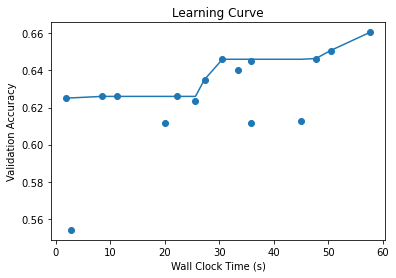

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1-np.array(valid_loss_history))
plt.plot(time_history, 1-np.array(best_valid_loss_history))
plt.show()

## 3. Customized Learner

Some experienced automl users may have a preferred model to tune or may already have a reasonably by-hand-tuned model before launching the automl experiment. They need to select optimal configurations for the customized model mixed with standard built-in learners. 

FLAML can easily incorporate customized/new learners (preferably with sklearn API) provided by users in a real-time manner, as demonstrated below.

### Example of Regularized Greedy Forest

[Regularized Greedy Forest](https://arxiv.org/abs/1109.0887) (RGF) is a machine learning method currently not included in FLAML. The RGF has many tuning parameters, the most critical of which are: `[max_leaf, n_iter, n_tree_search, opt_interval, min_samples_leaf]`. To run a customized/new learner, the user needs to provide the following information:
* an implementation of the customized/new learner
* a list of hyperparameter names and types
* rough ranges of hyperparameters (i.e., upper/lower bounds)
* choose initial value corresponding to low cost for cost-related hyperparameters (e.g., initial value for max_leaf and n_iter should be small)

In this example, the above information for RGF is wrapped in a python class called *MyRegularizedGreedyForest* that exposes the hyperparameters.

In [12]:
''' BaseEstimator is the parent module for a customized learner '''
from flaml.model import BaseEstimator
from flaml.space import ConfigSearchInfo
''' import the original implementation of RGF from rgf.sklearn package'''
from rgf.sklearn import RGFClassifier, RGFRegressor


class MyRegularizedGreedyForest(BaseEstimator):

    # search space
    params_configsearch_info = {
        'max_leaf': ConfigSearchInfo(name = 'max_leaf', type = int, lower = 4, init = 4, upper = 10000),
        'n_iter': ConfigSearchInfo(name = 'n_iter', type = int, lower = 1, init = 1, upper = 32768),
        'n_tree_search': ConfigSearchInfo(name = 'n_tree_search', type = int, lower = 1, init = 1, upper = 32768),
        'opt_interval': ConfigSearchInfo(name = 'opt_interval', type = int, lower = 1, init = 100, upper = 10000),
        'learning_rate': ConfigSearchInfo(name = 'learning_rate', type = float, lower = 0.01, init = 1.0, upper = 20.0),
        'min_samples_leaf': ConfigSearchInfo(name = 'min_samples_leaf', type = int, lower = 1, init = 20, upper = 20)
    }
    
    def __init__(self, objective_name = 'binary:logistic', n_jobs = 1, max_leaf = 1000, 
    n_iter = 1, n_tree_search = 1, opt_interval = 1, learning_rate = 1.0, min_samples_leaf = 1):

        '''regression for RGFRegressor; binary:logistic and multiclass for RGFClassifier'''
        self.objective_name = objective_name

        if 'regression' in objective_name:
            self.estimator_class = RGFRegressor
        else:
            self.estimator_class = RGFClassifier

        # round integer hyperparameters
        self.params = {
            'max_leaf': int(round(max_leaf)),
            'n_iter': int(round(n_iter)),
            'n_tree_search': int(round(n_tree_search)),
            'opt_interval': int(round(opt_interval)),
            'learning_rate': learning_rate,
            'min_samples_leaf':int(round(min_samples_leaf))
        }    


### Add Customized Learner and Run FLAML AutoML

After adding RGF into the list of learners, we run automl by tuning hyperpameters of RGF as well as the default learners. 

In [13]:
''' add a new learner RGF'''
automl = AutoML()
automl.add_learner(learner_name = 'RGF', learner_class = MyRegularizedGreedyForest)

In [14]:
settings = {
    "time_budget": 60, # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['RGF', 'lgbm', 'rf', 'xgboost'], # list of ML learners
    "task": 'classification', # task type    
    "sample": True, # whether to subsample training data
    "log_file_name": 'airlines_experiment.log', # cache directory of flaml log files 
    "log_training_metric": True, # whether to log training metric
}

'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 12-15 06:56:56] {660} INFO - List of ML learners in AutoML Run: ['RGF', 'lgbm', 'rf', 'xgboost']
[flaml.automl: 12-15 06:56:56] {665} INFO - Evaluation method: holdout
[flaml.automl: 12-15 06:56:56] {683} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 12-15 06:56:57] {327} INFO - Using StratifiedKFold
[flaml.automl: 12-15 06:56:57] {728} INFO - iteration 0  current learner RGF
[flaml.automl: 12-15 06:56:58] {793} INFO -  at 2.2s,	best RGF's error=0.3764,	best RGF's error=0.3764
[flaml.automl: 12-15 06:56:58] {728} INFO - iteration 1  current learner RGF
[flaml.automl: 12-15 06:57:00] {793} INFO -  at 4.5s,	best RGF's error=0.3764,	best RGF's error=0.3764
[flaml.automl: 12-15 06:57:00] {728} INFO - iteration 2  current learner lgbm
[flaml.automl: 12-15 06:57:00] {793} INFO -  at 4.6s,	best lgbm's error=0.3790,	best RGF's error=0.3764
[flaml.automl: 12-15 06:57:00] {728} INFO - iteration 3  current learner lgbm
[flaml.automl: 12-15 06:57:01] {793} INFO -  at 4.8